In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moulimabera","key":"26f354fe942347d2b548a3bd97f8e65e"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                 DAIGT V2 Train Dataset                               29MB  2023-11-16 01:38:36           1568        158  1.0              
muhammadbinimran/housing-price-prediction-data                  Housing Price Prediction Data                       763KB  2023-11-21 17:56:32           7017        125  1.0              
thedevastator/netflix-imdb-scores                               Netflix IMDB Scores                                 699KB  2023-12-03 14:10:34           2294         40  1.0              
thedevastator/spotify-tracks-genre-dataset                  

In [8]:
! chmod 600 /content/kaggle.json

In [9]:
! kaggle kernels output malikdiyaolu/rotten-fruit-classification -p /path/to/dest

Kernel log downloaded to /path/to/dest/rotten-fruit-classification.log 


In [10]:
! kaggle datasets download -d swoyam2609/fresh-and-stale-classification

100% 2.83G/2.84G [00:34<00:00, 31.6MB/s]
100% 2.84G/2.84G [00:34<00:00, 88.8MB/s]


In [11]:
! unzip fresh-and-stale-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_5372.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_54.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6186.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6285.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6551.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6565.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6985.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_7173.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_7306.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp 

In [12]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.7 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
from torchvision import models
import cv2 as op

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

<ipython-input-13-0e210fa3d5e0>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


('1.23.5', 'cpu')

In [14]:
TRAIN_PATH = 'dataset/Train'
TEST_PATH = 'dataset/Test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []

    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))

    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })

    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

((23619, 3), (6738, 3))

In [15]:
df_train.drop(df_train[(df_train['fruit'] == 'capsicum') & (df_train['fruit'] == 'bittergourd')].index, inplace = True)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'potato' if x == 'patato' else x)

In [16]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(30357, 3)

<Axes: xlabel='fruit', ylabel='count'>

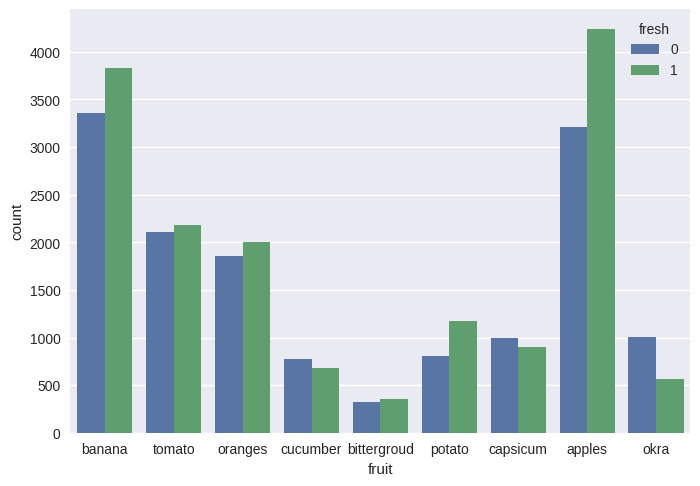

In [17]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')

In [18]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 1500:
        df_temp = df[df['fruit'] == key].sample(n = 1500)
    else:
        df_temp = df[df['fruit'] == key]

    df_new = pd.concat([df_new, df_temp], axis = 0)

df_new.shape

(12635, 3)

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_new['fruit_label'] = le.fit_transform(df_new['fruit'])
df_new.shape

(12635, 4)

In [20]:
df_new.head()

,filename,fruit,fresh,fruit_label
2286,dataset/Test/freshapples/a_f210.png,apples,0,0
4027,dataset/Train/rottenapples/rotated_by_75_Scree...,apples,1,0
5189,dataset/Train/rottenapples/vertical_flip_Scree...,apples,1,0
2274,dataset/Test/freshapples/rotated_by_45_Screen ...,apples,0,0
8691,dataset/Train/freshapples/rotated_by_30_Screen...,apples,0,0


<Axes: xlabel='fruit', ylabel='count'>

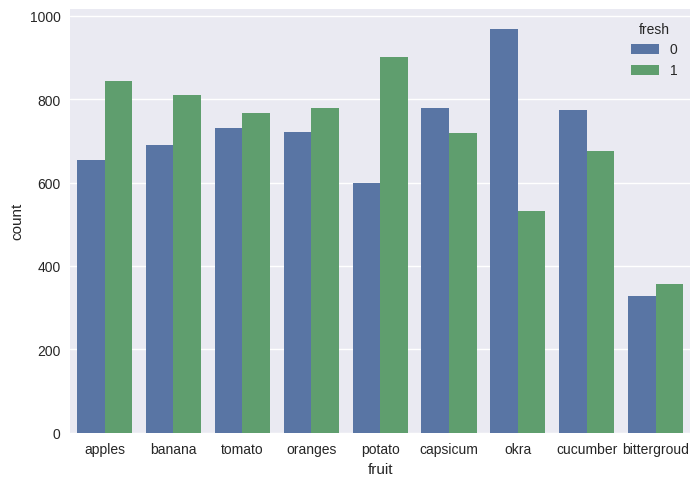

In [21]:
sea.countplot(x = 'fruit', data = df_new, hue = 'fresh')

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_new, test_size = 0.15, stratify = df_new['fruit_label'])

df_train.shape, df_val.shape

((10739, 4), (1896, 4))

<Axes: xlabel='fruit_label', ylabel='count'>

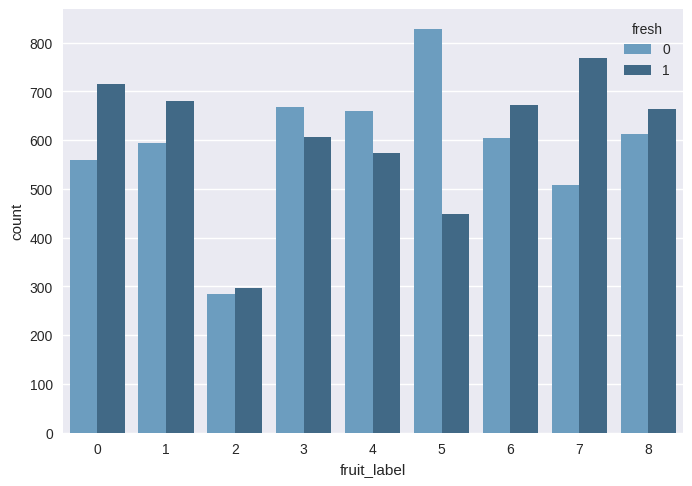

In [23]:
sea.countplot(x = 'fruit_label', data = df_train, hue = 'fresh', palette = 'Blues_d')

<Axes: xlabel='fruit', ylabel='count'>

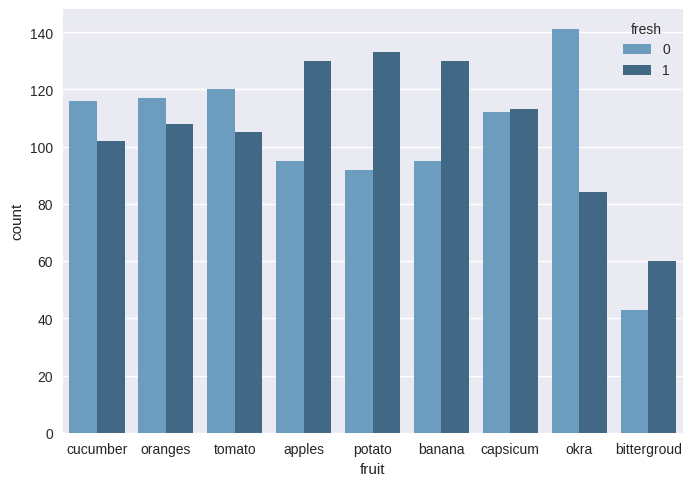

In [24]:
sea.countplot(x = 'fruit', data = df_val, hue = 'fresh', palette = 'Blues_d')

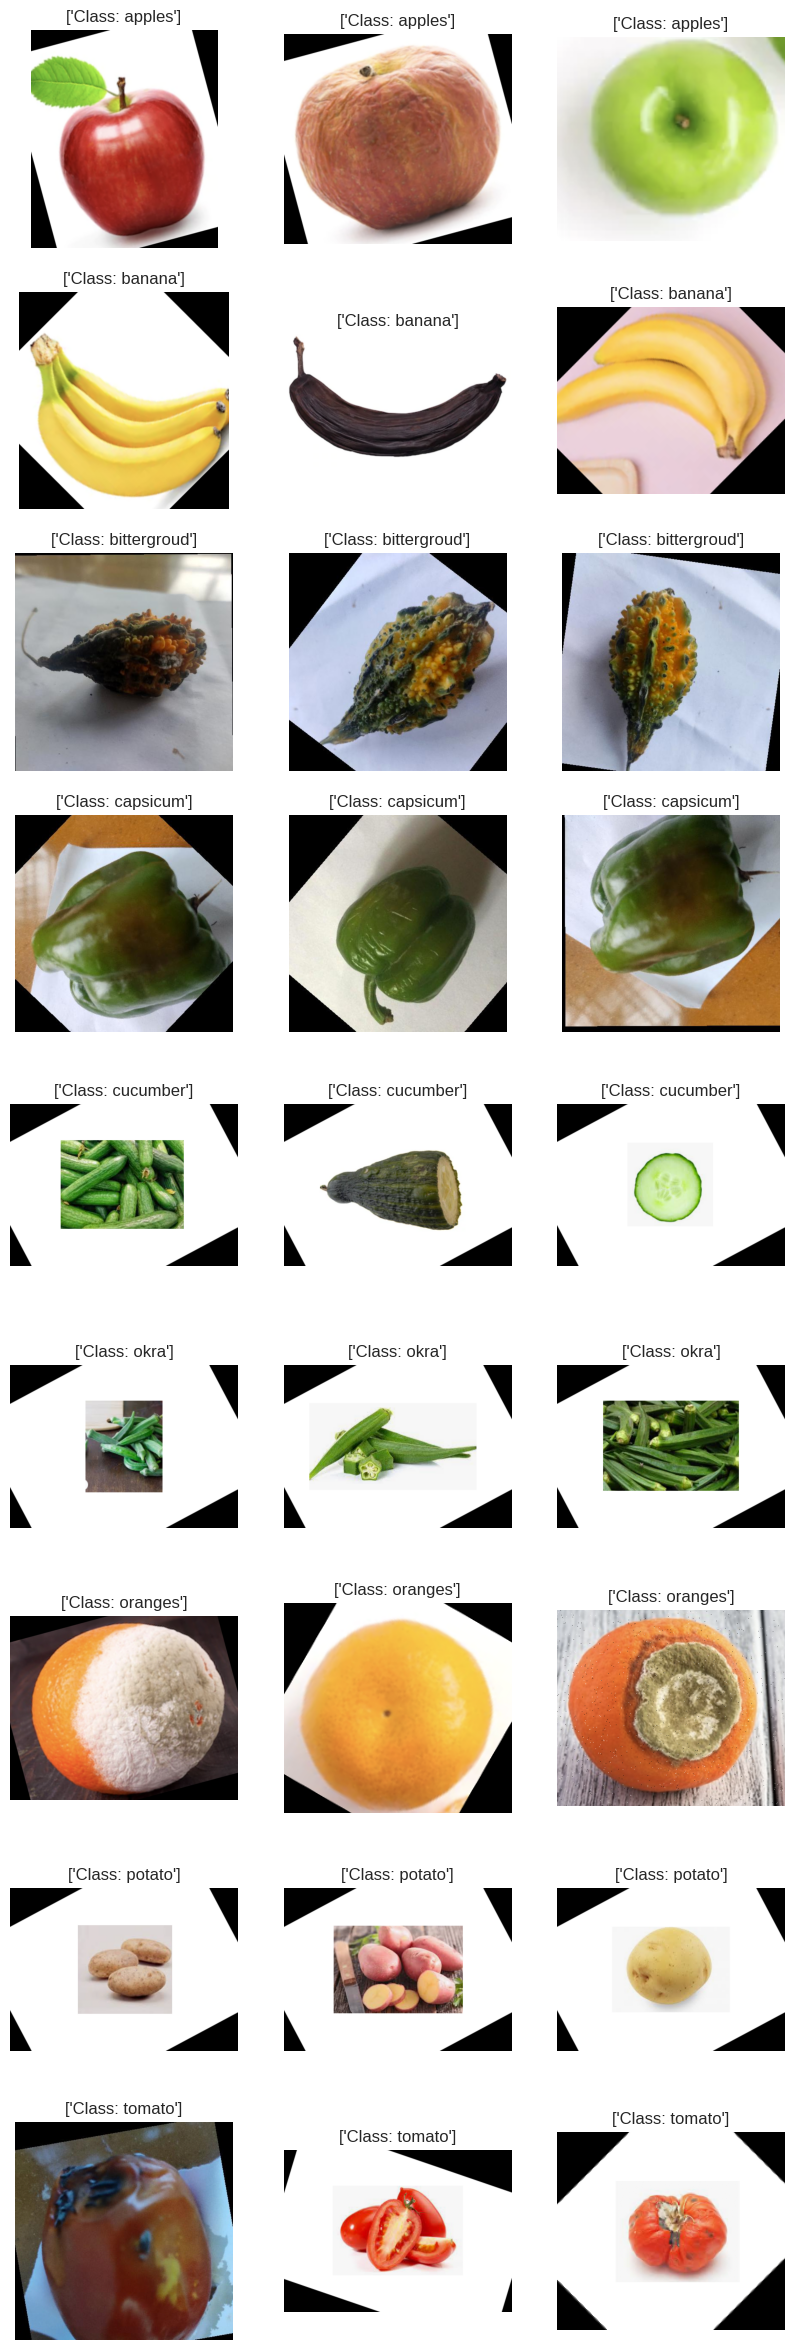

In [25]:
def load_image(path):
    img = plt.imread(path)
    return img

counter = 0

plt.figure(figsize = (10, 30))

for i in range(9):
    for path in df_train[df_train['fruit_label'] == i].sample(n = 3)['filename']:
        plt.subplot(9, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + le.inverse_transform([i]))
        counter += 1

plt.show()

In [26]:
def image_transform(img, p = 0.5, training = True):
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx][2])
        fruit = torch.tensor(self.df.iloc[idx][3])

        img = image_transform(img, p = 0.5, training = self.training)

        return img, fruit, fresh

In [27]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [28]:
a, b, c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
del(a)
del(b)
del(c)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array 

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64])


In [29]:
import math

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7

        self.base = torchvision.models.resnet18(pretrained = True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()

        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )

        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )

        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params' : self.base.parameters(), 'lr': 1e-5},
            {'params' : self.block1.parameters(),  'lr': 3e-4}
        ])

        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr = 3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr = 3e-4)

        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = 9)
        self.fresh_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 2)

        self.TRAIN_BATCHES = math.ceil(len(train_dataset)/BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset)/BATCH_SIZE)
        self.history = {'train_loss': [], 'val_loss': [],
                    'train_acc_fruit': [], 'train_acc_fresh': [],
                    'val_acc_fruit': [], 'val_acc_fresh': []}


    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)

        return y1, y2


    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

        self.optimizer2.zero_grad()
        l1 = l1.clone()  # Avoid inplace operation
        l1.backward(retain_graph=True)
        self.optimizer2.step()

        self.optimizer3.zero_grad()
        l2 = l2.clone()  # Avoid inplace operation
        l2.backward(retain_graph=True)
        self.optimizer3.step()

        loss = self.alpha * l1 + (1 - self.alpha) * l2
        self.optimizer1.zero_grad()
        loss.backward()
        self.optimizer1.step()

        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, dim=1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, dim=1), y2)

        return loss, fruit_acc, fresh_acc


    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
            return loss, fruit_acc, fresh_acc
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)


    def train(self, epochs = 5):

        for epoch in tqdm(range(epochs)):

            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0

            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()

            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()

            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]

            self.update_history( train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)

            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(epoch, train_loss, train_fruit, train_fresh,val_loss, val_fruit, val_fresh))


In [33]:
import torch
import torch.nn as nn
import torchvision
import torchmetrics
import math
from tqdm import tqdm

# Assuming you have defined BATCH_SIZE, train_loader, and val_loader somewhere

class Model(nn.Module):
    def __init__(self):
        torch.autograd.set_detect_anomaly(True)
        super().__init__()
        self.alpha = 0.7

        self.base = torchvision.models.resnet18(pretrained=True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()

        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )

        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )

        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params': self.base.parameters(), 'lr': 1e-5},
            {'params': self.block1.parameters(), 'lr': 3e-4}
        ])

        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr=3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr=3e-4)

        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=9)
        self.fresh_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2)

        self.TRAIN_BATCHES = math.ceil(len(train_dataset) / BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset) / BATCH_SIZE)
        self.history = {'train_loss': [], 'val_loss': [],
                        'train_acc_fruit': [], 'train_acc_fresh': [],
                        'val_acc_fruit': [], 'val_acc_fresh': []}

    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)
        return y1, y2

    def train_step(self, x, y1, y2):
       pred1, pred2 = self.forward(x)
       l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

       self.optimizer2.zero_grad()
       l1.backward(retain_graph=True)
       self.optimizer2.step()

       self.optimizer3.zero_grad()
       l2.backward(retain_graph=True)
       self.optimizer3.step()

       loss = self.alpha * l1 + (1 - self.alpha) * l2
       self.optimizer1.zero_grad()
       loss.backward()
       self.optimizer1.step()

       fruit_acc = self.fruit_accuracy(torch.argmax(pred1, dim=1), y1)
       fresh_acc = self.fresh_accuracy(torch.argmax(pred2, dim=1), y2)

       return loss, fruit_acc, fresh_acc


    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, dim=1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, dim=1), y2)

            return loss, fruit_acc, fresh_acc

    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)

    def train(self, epochs=5):
        for epoch in tqdm(range(epochs)):
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0

            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()

            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()

            train_loss, train_fruit, train_fresh = [x / self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x / self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]

            self.update_history(train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)

            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(
                epoch, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh))


In [34]:
model = Model().to(device)

In [35]:
model.train(epochs= 5)

  0%|          | 0/168 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:251: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forev

RuntimeError: ignored

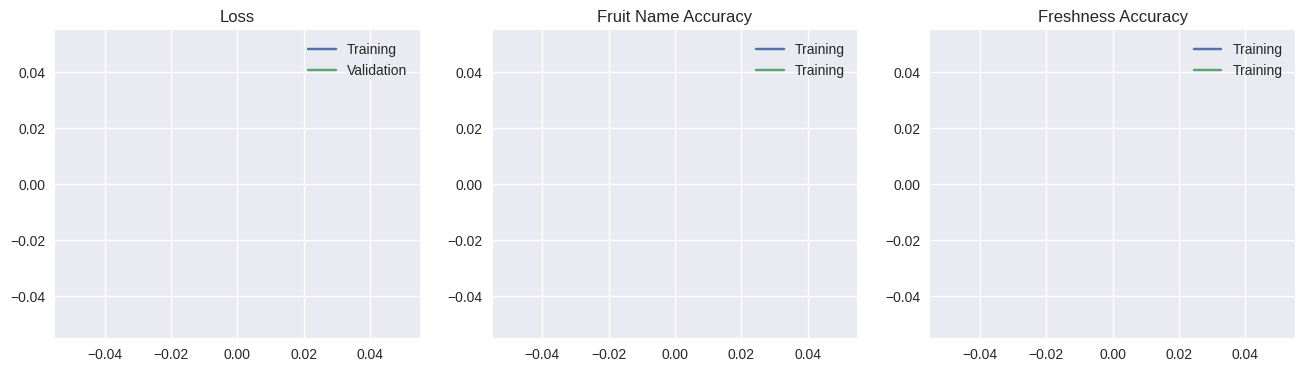

In [36]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model.history['train_loss'], label = 'Training')
plt.plot(model.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model.history['train_acc_fruit'], label = 'Training')
plt.plot(model.history['val_acc_fruit'], label = 'Training')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model.history['train_acc_fresh'], label = 'Training')
plt.plot(model.history['val_acc_fresh'], label = 'Training')
plt.legend()

In [37]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(val_loader):
        pred = model(x.to(device))

        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)


len(fruit), len(fresh), len(preds1), len(preds2)

100%|██████████| 30/30 [03:52<00:00,  7.76s/it]


(1896, 1896, 1896, 1896)

Text(0.5, 1.0, 'Confusion Matrix for Fruit Names')

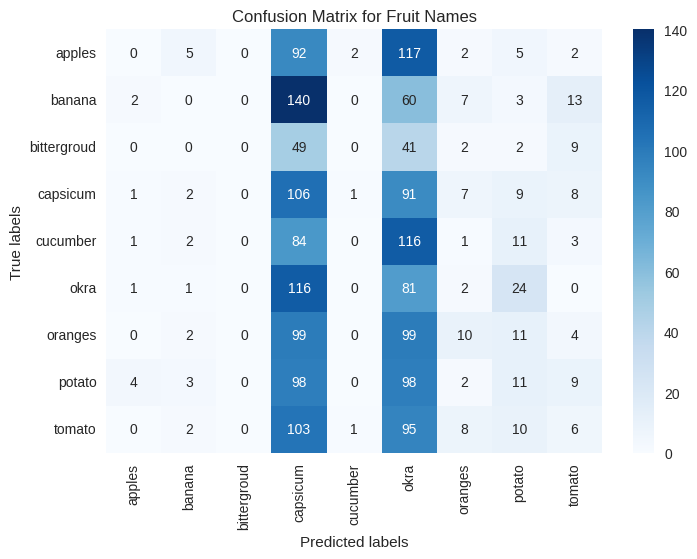

In [38]:
from sklearn.metrics import confusion_matrix

class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')

Text(0.5, 1.0, 'Confusion Matrix for Freshness')

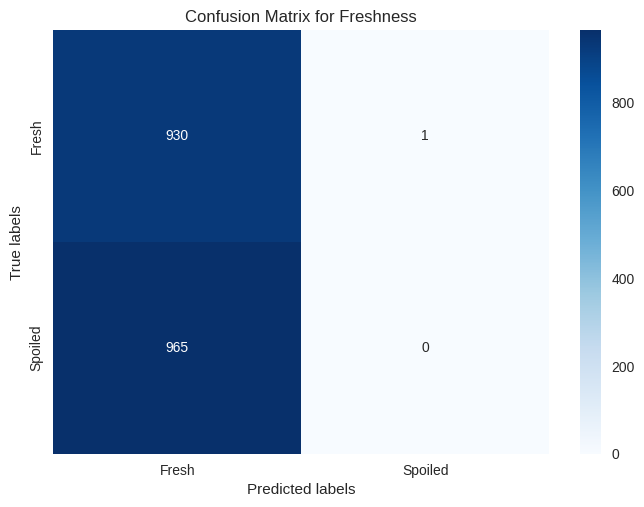

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [40]:
from sklearn.metrics import classification_report

print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

              precision    recall  f1-score   support

      apples       0.00      0.00      0.00       225
      banana       0.00      0.00      0.00       225
 bittergroud       0.00      0.00      0.00       103
    capsicum       0.12      0.47      0.19       225
    cucumber       0.00      0.00      0.00       218
        okra       0.10      0.36      0.16       225
     oranges       0.24      0.04      0.08       225
      potato       0.13      0.05      0.07       225
      tomato       0.11      0.03      0.04       225

    accuracy                           0.11      1896
   macro avg       0.08      0.11      0.06      1896
weighted avg       0.08      0.11      0.06      1896

              precision    recall  f1-score   support

       Fresh       0.49      1.00      0.66       931
     Spoiled       0.00      0.00      0.00       965

    accuracy                           0.49      1896
   macro avg       0.25      0.50      0.33      1896
weighted avg       0.24

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
